# Spatial and temporal analysis of greenhouse gas emissions transfers over the US electric grid

##### Guangyu Cai, Joe Franke, Amina Jackson, Jenni Nugent 


### Research Questions

1. How is electricity transferred on the U.S. electric grid between balancing authorities on a sub-annual timescale?
2. What is the spatial distribution of emissions and how does it compare to median household income?

### Project Motivation

- Spatial and temporal transfer of resources has important policy and environmental justice implications.
 

### Data Sources

- **U.S. Energy Information Administration**
    - `Form EIA-923`
        - URL: https://www.eia.gov/electricity/data/eia923/
        - Includes:
            - Plant-level fuel type
            - Monthly plant-level fuel consumption and electricity generation
    - `Form EIA-860`
        - URL: https://www.eia.gov/electricity/data/eia860/
        - Includes:
            - Power plant location (latitude and longitude)
            - Power plant balancing authority
    - `Form EIA-930`
        - URL: https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48?src=email
        - Includes: 
            - Hourly electric transfers between balancing authorities
- **Homeland Infrastructure Foundation-Level Data (HIFLD)**
    - `Control Areas` (Balancing Authority Shapefiles)
        - https://hifld-geoplatform.opendata.arcgis.com/search?q=control%20areas
- **U.S. Environmental Protection Agency**
    - `Greenhouse Gas Emissions Factors`
        - URL: https://www.epa.gov/climateleadership/ghg-emission-factors-hub
- **U.S. Census Bureau**
    - `Median Household Income` by tract (2018)
        - URL: https://data.census.gov/cedsci/table?q=median%20household%20income%202020&tid=ACSST5Y2020.S1901
    - `Census Tracts` (2018) shapefiles
        - URL: https://www.census.gov/cgi-bin/geo/shapefiles/index.php

### Workflow Overview

- Import Packages
- U.S. Energy Information Administration Data Preparation
- Greenhouse Gas Emissions Estimate
- Data Preparation
    - Data Preparation Visualization 1: Balancing Authority Data
    - Data Preparation Visualization 2: Emissions and Location Dataframe
    - Data Preparation Visualization 3: Emissions and Fuel Type Dataframe
    - Data Preparation Visualization 3: Census Data Preparation
- Visualizations
    - Visualization 1: Map of BA-to-BA electric transfers
    - Visualization 2: Map of Point Source GHG Emissions
    - Visualization 3: Map of Power Plants & Fuel Type and Median Household Income


### Import Packages

In [32]:
import pandas as pd
import math
import geopandas as gpd
import matplotlib.pyplot as plt

### U.S. Energy Information Administration Data Preparation

- Import power plant location and balancing authority data from EIA-860
- Import plant-level fuel type, fuel consumption, and electricity generation data from EIA-923
    - Transform monthly data from wide format to long format

In [3]:
# Import plant location data from Form EIA-860
plantData_2018 = pd.read_csv('./data/EIA Data/2___Plant_Y2018.csv',header=1)
keep_columns1 = (['Plant Code','Latitude',
                  'Longitude','Balancing Authority Code'])
plantData_2018 = plantData_2018[keep_columns1] 
plantData_2018.head()

,Plant Code,Latitude,Longitude,Balancing Authority Code
0,2,33.458665,-87.356823,SOCO
1,3,31.006900,-88.010300,SOCO
2,4,32.583889,-86.283056,SOCO
3,7,34.012800,-85.970800,SOCO
4,8,33.644344,-87.196486,SOCO


In [4]:
# Import monthly, plant-level fuel cosnumption and generation data from Form EIA-923
fuelAndGeneration_2018 = pd.read_csv('./data/EIA Data/EIA923_Schedules_2_3_4_5_M_12_2018_Final_Revision.csv',header=5)
fuelAndGeneration_2018.rename(columns = {'Plant Id': 'Plant ID',
                                         'Combined Heat And\nPower Plant': 'Combined Heat & Power Plant',
                                         'Plant State': 'State',
                                         'Reported\nPrime Mover': 'Reported Prime Mover', 
                                         'Reported\nFuel Type Code':'Reported Fuel Type Code',
                                         'Elec_MMBtu\nJanuary': 'Elec_MMBtu_Jan', 
                                         'Elec_MMBtu\nFebruary': 'Elec_MMBtu_Feb', 
                                         'Elec_MMBtu\nMarch': 'Elec_MMBtu_Mar',
                                         'Elec_MMBtu\nApril': 'Elec_MMBtu_Apr', 
                                         'Elec_MMBtu\nMay': 'Elec_MMBtu_May', 
                                         'Elec_MMBtu\nJune': 'Elec_MMBtu_Jun',
                                         'Elec_MMBtu\nJuly': 'Elec_MMBtu_Jul', 
                                         'Elec_MMBtu\nAugust': 'Elec_MMBtu_Aug', 
                                         'Elec_MMBtu\nSeptember': 'Elec_MMBtu_Sep',
                                         'Elec_MMBtu\nOctober': 'Elec_MMBtu_Oct', 
                                         'Elec_MMBtu\nNovember': 'Elec_MMBtu_Nov', 
                                         'Elec_MMBtu\nDecember': 'Elec_MMBtu_Dec',
                                         'Netgen\nJanuary':'Netgen_Jan', 
                                         'Netgen\nFebruary':'Netgen_Feb', 
                                         'Netgen\nMarch':'Netgen_Mar',
                                         'Netgen\nApril':'Netgen_Apr',
                                         'Netgen\nMay':'Netgen_May', 
                                         'Netgen\nJune':'Netgen_Jun', 
                                         'Netgen\nJuly':'Netgen_Jul', 
                                         'Netgen\nAugust':'Netgen_Aug',
                                         'Netgen\nSeptember':'Netgen_Sep', 
                                         'Netgen\nOctober':'Netgen_Oct', 
                                         'Netgen\nNovember':'Netgen_Nov', 
                                         'Netgen\nDecember':'Netgen_Dec'}, inplace = True) 

In [5]:
# Create a function that converts strings to floats in EIA-923 Files
def string2Float(dfRow):
    if type(dfRow) == str:
        if dfRow == '.': #replace missing values with 0
            x = 0
        elif dfRow == 'nan': #replace missing values with 0
            x = 0
        else:
            x = float(dfRow.replace(',','')) #remove commas from values and convert to float type
    if type(dfRow) == float:
        if math.isnan(dfRow): #replace missing values with 0
            x = 0
        else:
            x = dfRow
    return x

In [7]:
# Convert String Numbers to Float Values
convert_columns = (['Elec_MMBtu_Jan', 'Elec_MMBtu_Feb', 'Elec_MMBtu_Mar', 'Elec_MMBtu_Apr', 
                    'Elec_MMBtu_May','Elec_MMBtu_Jun', 'Elec_MMBtu_Jul', 'Elec_MMBtu_Aug', 
                    'Elec_MMBtu_Sep', 'Elec_MMBtu_Oct','Elec_MMBtu_Nov', 'Elec_MMBtu_Dec',
                    'Netgen_Jan', 'Netgen_Feb', 'Netgen_Mar', 'Netgen_Apr', 
                    'Netgen_May','Netgen_Jun', 'Netgen_Jul', 'Netgen_Aug', 
                    'Netgen_Sep', 'Netgen_Oct','Netgen_Nov', 'Netgen_Dec'])
for col in convert_columns:
    fuelAndGeneration_2018[col] = fuelAndGeneration_2018.apply(lambda row: string2Float(row[col]),axis=1)
#fuelAndGeneration_2018

In [8]:
# Keep generation data and create dataframe of generation
keep_columns2 = (['Plant ID', 'Combined Heat & Power Plant', 'Plant Name',
                 'State', 'NERC Region', 'Reported Prime Mover', 'Reported Fuel Type Code',
                 'Netgen_Jan', 'Netgen_Feb', 'Netgen_Mar', 'Netgen_Apr', 
                 'Netgen_May','Netgen_Jun', 'Netgen_Jul', 'Netgen_Aug', 
                 'Netgen_Sep', 'Netgen_Oct','Netgen_Nov', 'Netgen_Dec'])
generation_2018 = fuelAndGeneration_2018[keep_columns2] 

In [9]:
# Keep fuel consumption data and create dataframe of fuel consumption
keep_columns3 = (['Plant ID', 'Combined Heat & Power Plant', 'Plant Name',
                 'State', 'NERC Region', 'Reported Prime Mover', 'Reported Fuel Type Code',
                 'Elec_MMBtu_Jan', 'Elec_MMBtu_Feb', 'Elec_MMBtu_Mar', 'Elec_MMBtu_Apr', 
                 'Elec_MMBtu_May','Elec_MMBtu_Jun', 'Elec_MMBtu_Jul', 'Elec_MMBtu_Aug', 
                 'Elec_MMBtu_Sep', 'Elec_MMBtu_Oct','Elec_MMBtu_Nov', 'Elec_MMBtu_Dec'])
fuel_2018 = fuelAndGeneration_2018[keep_columns3] 

In [10]:
# Melt generation data from wide to long format
genMonthsList = ['Netgen_Jan', 'Netgen_Feb', 'Netgen_Mar', 'Netgen_Apr', 
                 'Netgen_May','Netgen_Jun', 'Netgen_Jul', 'Netgen_Aug', 
                 'Netgen_Sep', 'Netgen_Oct','Netgen_Nov', 'Netgen_Dec']
monthNum1 = list(range(1, 13))
genMonths = dict(zip(genMonthsList,monthNum1))
netGenMelted = generation_2018.melt(id_vars=['Plant ID', 'Combined Heat & Power Plant', 'Plant Name', 
                                'State', 'NERC Region', 'Reported Prime Mover', 'Reported Fuel Type Code'], 
                                 value_vars=genMonthsList, 
                                 value_name='Net Generation (MWh)',
                                 var_name= 'Month')
generation_2018 = netGenMelted.assign(Month=netGenMelted['Month'].map(genMonths)) 
#generation_2018

In [11]:
#Melt fuel consumption from wide to long format
fuelMonthsList = ['Elec_MMBtu_Jan', 'Elec_MMBtu_Feb', 'Elec_MMBtu_Mar', 'Elec_MMBtu_Apr', 
                 'Elec_MMBtu_May','Elec_MMBtu_Jun', 'Elec_MMBtu_Jul', 'Elec_MMBtu_Aug', 
                 'Elec_MMBtu_Sep', 'Elec_MMBtu_Oct','Elec_MMBtu_Nov', 'Elec_MMBtu_Dec']
monthNum1 = list(range(1, 13))
fuelMonths = dict(zip(fuelMonthsList,monthNum1))
fuelMelted = fuel_2018.melt(id_vars=['Plant ID', 'Combined Heat & Power Plant', 'Plant Name', 
                                'State', 'NERC Region', 'Reported Prime Mover', 'Reported Fuel Type Code'], 
                                 value_vars=fuelMonthsList, 
                                 value_name='Electric Fuel Consumption (MMBtu)',
                                 var_name= 'Month')
fuel_2018 = fuelMelted.assign(Month=fuelMelted['Month'].map(fuelMonths)) 
#fuel_2018

In [12]:
# Merge long-format fuel data and long-format generation data
fuelAndGeneration_2018long =  fuel_2018.copy()
fuelAndGeneration_2018long['Net Generation (MWh)'] =  generation_2018['Net Generation (MWh)']
#fuelAndGeneration_2018long.to_csv('fuelAndGeneration_2018long1.csv')
fuelAndGeneration_2018long.head()

,Plant ID,Combined Heat & Power Plant,Plant Name,State,NERC Region,Reported Prime Mover,Reported Fuel Type Code,Month,Electric Fuel Consumption (MMBtu),Net Generation (MWh)
0,2,N,Bankhead Dam,AL,SERC,HY,WAT,1,0.0,-36.0
1,3,N,Barry,AL,SERC,CA,NG,1,56603.0,264566.0
2,3,N,Barry,AL,SERC,CT,NG,1,5202919.0,493620.0
3,3,N,Barry,AL,SERC,CT,SUB,1,0.0,0.0
4,3,N,Barry,AL,SERC,ST,BIT,1,4770781.0,474858.0


### Greenhouse Gas Emissions Estimate

- Estimate GHG emissions based on EIA-923 fuel consumption data and emissions factors from the EPA

In [13]:
# Create Function for Estimating GHG emissions
def GHG_estimate(fuelType,fuelConsumption,netGeneration):
    CH4_GWP = 25
    N2O_GWP = 298
    G_TO_KG = 1/1000
    KG_TO_LBS = 1/2.204623  
    
    if fuelType == "NG": 
        """Natural Gas"""
        CO2eqv = 53.06 + 1.0*CH4_GWP*G_TO_KG + 0.10*N2O_GWP*G_TO_KG

    elif fuelType == "ANT": 
        """Anthracite Coal"""
        CO2eqv = 103.69 + 11*CH4_GWP*G_TO_KG + 1.6*N2O_GWP*G_TO_KG 
    elif fuelType == "BIT": 
        """Bituminous Coal"""
        CO2eqv = 93.28 + 11*CH4_GWP*G_TO_KG + 1.6*N2O_GWP*G_TO_KG 
    elif fuelType == "LIG": 
        """Lignite Coal"""
        CO2eqv = 97.72 + 11*CH4_GWP*G_TO_KG + 1.6*N2O_GWP*G_TO_KG 
    elif fuelType == "SUB": 
        """Sub-bituminous Coal"""
        CO2eqv = 97.17 + 11*CH4_GWP*G_TO_KG + 1.6*N2O_GWP*G_TO_KG 
    
    elif fuelType == "JF": 
        """Jet Fuel [Kerosene-Type Jet Fuel]"""
        CO2eqv = 72.22 + 3.0*CH4_GWP*G_TO_KG + 0.60*N2O_GWP*G_TO_KG
    elif fuelType == "PG": 
        """Propane Gas"""
        CO2eqv = 61.46 + 3.0*CH4_GWP*G_TO_KG + 0.60*N2O_GWP*G_TO_KG
    elif fuelType == "PC": 
        """Petroleum Coke - [Solid]"""
        CO2eqv = 102.41 + 32*CH4_GWP*G_TO_KG + 4.2*N2O_GWP*G_TO_KG     
    elif fuelType == "WDS": 
        """Wood/Wood Waste Solids [Wood and Wood Residuals]"""            
        CO2eqv = 93.80 + 7.2*CH4_GWP*G_TO_KG + 3.6*N2O_GWP*G_TO_KG 
    elif fuelType == "KER": 
        """Kerosene"""
        CO2eqv = 75.20 + 3.0*CH4_GWP*G_TO_KG + 0.60*N2O_GWP*G_TO_KG 
    elif fuelType == "DFO": 
        """Distillate Fuel Oil (including diesel, No. 1, No. 2, and No. 4 fuel oils) [No. 1, No. 2, No. 3]"""
        tempCO2 = (73.25 + 73.96 + 75.04)/3 #Average No.1, No.2, No.4
        CO2eqv = tempCO2 + 3.0*CH4_GWP*G_TO_KG + 0.60*N2O_GWP*G_TO_KG  
    elif fuelType == "LFG": 
        """Landfill Gas"""
        CO2eqv = 52.07 + 3.2*CH4_GWP*G_TO_KG + 0.63*N2O_GWP*G_TO_KG 
    elif fuelType == "AB": 
        """Agricultural By-Products"""
        CO2eqv = 118.17 + 32*CH4_GWP*G_TO_KG + 4.2*N2O_GWP*G_TO_KG 
    elif fuelType == "RFO": 
        """Residual Fuel Oil (incl. Nos. 5 & 6 fuel oils, and bunker C fuel oil) [No. 5, No.6]"""
        tempCO2 = (72.93 + 75.10)/2 #Average No.5, No.6
        CO2eqv = tempCO2 + 3.0*CH4_GWP*G_TO_KG + 0.60*N2O_GWP*G_TO_KG 
    elif fuelType == "TDF": 
        """Tire-Derived Fuels [Tires]"""
        CO2eqv = 85.97 + 32*CH4_GWP*G_TO_KG + 4.2*N2O_GWP*G_TO_KG  
    elif fuelType == "OBG": 
        """Other Biomass Gas"""
        CO2eqv = 52.07 + 3.2*CH4_GWP*G_TO_KG + 0.63*N2O_GWP*G_TO_KG 
    else:                
        CO2eqv = 0
    
    GHG = (CO2eqv * fuelConsumption) * KG_TO_LBS # ((kg/MMbtu) * MMBtu) 
    return round(GHG, 4)

In [14]:
# Estimate GHG Emissions
fuelAndGeneration_2018long['GHG Estimate (lbs)'] = fuelAndGeneration_2018long.apply(lambda row: GHG_estimate(row['Reported Fuel Type Code'],row['Electric Fuel Consumption (MMBtu)'],row['Net Generation (MWh)']),axis=1)
fuelAndGeneration_2018long = fuelAndGeneration_2018long[ fuelAndGeneration_2018long['GHG Estimate (lbs)'] > 0 ] 
#fuelAndGeneration_2018long.to_csv('fuelAndGeneration_2018long.csv')
#fuelAndGeneration_2018long

In [15]:
# Aggregate GHG Emissions by plant
fuelAndGeneration_2018_AggPlant = fuelAndGeneration_2018long.groupby(by = ['Month','Plant ID'],as_index=False).agg( {'GHG Estimate (lbs)': ['sum'],
                                                                                                                    'Net Generation (MWh)': ['sum']})

fuelAndGeneration_2018_AggPlant.columns = fuelAndGeneration_2018_AggPlant.columns.droplevel(1)
fuelAndGeneration_2018_AggPlant.head()

,Month,Plant ID,GHG Estimate (lbs),Net Generation (MWh)
0,1,3,3.385828e+08,1267682.0
1,1,7,4.145301e+06,14592.0
2,1,8,2.683336e+08,665047.0
3,1,9,1.432610e+06,3601.0
4,1,10,2.123426e+07,72463.0


### Data Preparation Visualization 1: Balancing Authority Data

- Match Balancing Authority Acronyms with Balancing authority shapefiles
- Find the centroid of the balancing authorities
- Import electricty transfer data between balancing authorities

In [19]:
# Import Balancing Authority Shape Data
balancing_Authorities = gpd.read_file('./data/BA Geometry/Control_Areas.geojson')
balancing_Authorities = balancing_Authorities.set_index('OBJECTID')
balancing_Authorities = balancing_Authorities[(balancing_Authorities['STATE'] != 'AK') & (balancing_Authorities['STATE'] != 'HI' )]
#print(balancing_Authorities.crs)

In [20]:
# Import Balacing Authority Acronym List
BA_Acronyms = pd.read_csv('./data/BA Geometry/Balancing Authorities EIA930 HIFDL 2018.csv')
BA_Acronyms

# Merge Balancing Authority Shape Data with Acronyms
BA_Acronyms = balancing_Authorities.merge(BA_Acronyms, left_on='NAME', right_on='HIFDL Name 2022', how='right')
BA_Acronyms = BA_Acronyms[['BA Code', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'geometry', 'Lat', 'Long']]

# Projection
BA_Acronyms_3857 = BA_Acronyms.to_crs(epsg=3857)

# Find centroids
BA_Acronyms_3857['centroid'] = BA_Acronyms_3857.centroid

In [21]:
#Import electricity transfer data
transferData_2018 = pd.read_csv('./data/Transfer Data/Total.Monthly.Transfers 2018 4.6.2022.csv')
transferData_2018.head()

,origin,destination,Year,Month,monthlyTransferMWh
0,AEC,MISO,2018,1,119447
1,AEC,MISO,2018,2,67662
2,AEC,MISO,2018,3,41530
3,AEC,MISO,2018,4,30003
4,AEC,MISO,2018,5,50136


### Data Preparation Visualization 2: Emissions and Location Dataframe 

- Merge plant-level emissions data with plant location data

In [22]:
# Merge with plant-level GHG Emissions data with plant location data
fuelAndGeneration_2018_location =  pd.merge(fuelAndGeneration_2018_AggPlant,
                                                plantData_2018, 
                                                left_on=['Plant ID'], 
                                                right_on=['Plant Code'],
                                                how = 'left',
                                                suffixes =  ('', '_2'))
fuelAndGeneration_2018_location = fuelAndGeneration_2018_location[['Month', 'Plant ID', 'Latitude', 'Longitude', 'Balancing Authority Code',
                                                                           'GHG Estimate (lbs)', 'Net Generation (MWh)']] 
fuelAndGeneration_2018_location = fuelAndGeneration_2018_location[fuelAndGeneration_2018_location['Net Generation (MWh)'] > 0]
#fuelAndGeneration_2018_location.to_csv('fuelAndGeneration_2018_location.csv')
fuelAndGeneration_2018_location.head()

,Month,Plant ID,Latitude,Longitude,Balancing Authority Code,GHG Estimate (lbs),Net Generation (MWh)
0,1,3,31.006900,-88.010300,SOCO,3.385828e+08,1267682.0
1,1,7,34.012800,-85.970800,SOCO,4.145301e+06,14592.0
2,1,8,33.644344,-87.196486,SOCO,2.683336e+08,665047.0
3,1,9,31.756900,-106.375000,EPE,1.432610e+06,3601.0
4,1,10,32.601700,-87.781100,SOCO,2.123426e+07,72463.0


### Data Preparation Visualization 3: Emissions and Fuel Type Dataframe 

- Determine the primary fuel(s) used for each power plant
    - Aggregate various coal types together
    - By mass, most emissions come from coal and nattural gas

In [24]:
# Create a function to convert the codes of different coal type to a standard 'COAL'
def coal(fuelType):
    COAL_CODES = ['ANT','BIT','LIG','SUB','RC','WC']
    
    if fuelType in COAL_CODES:
        fuelType = 'COAL'
    
    return fuelType

In [25]:
# Convert the codes of different coal types to 'COAL'
fuelAndGeneration_2018long_Coal = fuelAndGeneration_2018long.copy()
fuelAndGeneration_2018long_Coal['Reported Fuel Type Code'] = fuelAndGeneration_2018long.apply(lambda row: coal(row['Reported Fuel Type Code']),axis=1)
#fuelAndGeneration_2018long_Coal

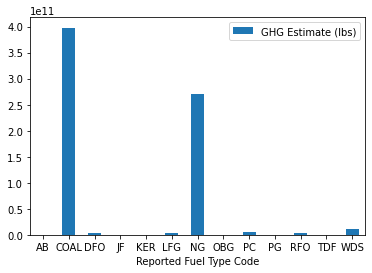

In [26]:
# Aggregate GHG Emissions by fuel type
emissions_byAllFuel_2018_Agg = fuelAndGeneration_2018long_Coal.groupby(by = ['Reported Fuel Type Code'],as_index=False).agg( {'GHG Estimate (lbs)': ['sum'],
                                                                                                                         'Net Generation (MWh)': ['sum']})

emissions_byAllFuel_2018_Agg.columns = emissions_byAllFuel_2018_Agg.columns.droplevel(1)
emissions_byAllFuel_2018_Agg['GHG emissions (lbs/MWh)'] = emissions_byAllFuel_2018_Agg['GHG Estimate (lbs)'] / emissions_byAllFuel_2018_Agg['Net Generation (MWh)']
ax = emissions_byAllFuel_2018_Agg.plot.bar(x='Reported Fuel Type Code', y='GHG Estimate (lbs)', rot=0)
#ax = emissions_byAllFuel_2018_Agg.plot.bar(x='Reported Fuel Type Code', y='GHG emissions (lbs/MWh)', rot=0)

#### Table 1: Fuel Type Codes

| Fuel Code | Fuel |
| ---       | ---  |
| AB | Agricultural By-Products |
| COAL | Coal |
| DFO | Distillate Fuel Oil |
| JF | Jet Fuel |
| KER | Kerosene |
| LFG | Landfill Gas |
| NG | Natural Gas |
| OBG | Other Biomass Gas |
| PC | Petroleum Coke |
| PG | Propane Gas |
| RFO | Residual Fuel Oil |
| TDF | Tire-Derived Fuels |
| WDS | Wood/Wood Waste Solids |


In [27]:
# Aggregate generation and emissions by plant and fuel type
fuelAndGeneration_2018_AggFuel = fuelAndGeneration_2018long_Coal.groupby(by = ['Month','Plant ID','Reported Fuel Type Code'],as_index=False).agg( {'GHG Estimate (lbs)': ['sum'],
                                                                                                                                              'Net Generation (MWh)': ['sum']})

fuelAndGeneration_2018_AggFuel.columns = fuelAndGeneration_2018_AggFuel.columns.droplevel(1)

# Keep emissions above a given threshold to get rid of secondary fuels
emissions_threshold3 = fuelAndGeneration_2018_AggFuel['GHG Estimate (lbs)'].quantile(.25)

fuelAndGeneration_2018_AggFuel_quantile = fuelAndGeneration_2018_AggFuel[fuelAndGeneration_2018_AggFuel['GHG Estimate (lbs)'] > emissions_threshold3]
#fuelAndGeneration_2018_AggFuel_quantile

# Keep emissions only for NG and Coal
fuelAndGeneration_2018_AggFuel_CoalNG = fuelAndGeneration_2018_AggFuel[fuelAndGeneration_2018_AggFuel['Reported Fuel Type Code'].isin(['NG','COAL']) ]
#fuelAndGeneration_2018_AggFuel_CoalNG

In [28]:
# Find the primary fuels for each plant

# What percentage of total plant generation is each fuel type responsible for?
fuelType_AggPlant =  pd.merge(fuelAndGeneration_2018_AggFuel_CoalNG,
                              fuelAndGeneration_2018_AggPlant,
                              left_on=['Plant ID','Month'], 
                              right_on=['Plant ID','Month'],
                              how = 'left',
                              suffixes =  ('', '_2'))

fuelType_AggPlant = fuelType_AggPlant[['Month','Plant ID', 'Reported Fuel Type Code', 
                                       'Net Generation (MWh)','Net Generation (MWh)_2']] 
#Keep fuels with generation greater than 0
fuelType_AggPlant = fuelType_AggPlant[fuelType_AggPlant['Net Generation (MWh)'] > 0] 
#Keep fuels that are more than 45% of total plant generation
fuelType_AggPlant = fuelType_AggPlant[(fuelType_AggPlant['Net Generation (MWh)'] / fuelType_AggPlant['Net Generation (MWh)_2']) > 0.30]
fuelType_AggPlant['% gen'] = (fuelType_AggPlant['Net Generation (MWh)'] / fuelType_AggPlant['Net Generation (MWh)_2']) * 100
#fuelType_AggPlant.to_csv('fuelType_AggPlant.csv')
#fuelType_AggPlant

In [29]:
# Create function for aggregting to a single fuel type
def aggFuelType(x):
    unique = []
    
    for val in x:
        if val not in unique:
            unique.append(val)
            
    unique.sort()
    
    if len(unique) == 1:
        unique = unique[0] 
    elif unique == ['COAL','NG']:
        unique = 'COAL_NG'
    else:
        unique = tuple(unique)
        
    return unique

In [30]:
#Aggregate by plant to find primary fuel type(s)
fuelType_AggPlant2 = fuelType_AggPlant.groupby(by = ['Plant ID','Month'],as_index=False).agg( {'Reported Fuel Type Code': [aggFuelType]})

fuelType_AggPlant2.columns = fuelType_AggPlant2.columns.droplevel(1)
#fuelType_AggPlant2['Reported Fuel Type Code'].value_counts()


In [31]:
# Merge plant emissions with fuel type
emissions_primaryFuelType =  pd.merge(fuelAndGeneration_2018_location,
                                        fuelType_AggPlant2, 
                                        left_on=['Plant ID','Month'], 
                                        right_on=['Plant ID','Month'],
                                        how = 'left',
                                        suffixes =  ('', '_2'))

emissions_primaryFuelType = emissions_primaryFuelType.dropna()
#emissions_primaryFuelType.to_csv('emissions_primaryFuelType.csv')
emissions_primaryFuelType.head()

,Month,Plant ID,Latitude,Longitude,Balancing Authority Code,GHG Estimate (lbs),Net Generation (MWh),Reported Fuel Type Code
0,1,3,31.006900,-88.010300,SOCO,3.385828e+08,1267682.0,COAL_NG
1,1,7,34.012800,-85.970800,SOCO,4.145301e+06,14592.0,NG
2,1,8,33.644344,-87.196486,SOCO,2.683336e+08,665047.0,COAL
3,1,9,31.756900,-106.375000,EPE,1.432610e+06,3601.0,NG
4,1,10,32.601700,-87.781100,SOCO,2.123426e+07,72463.0,NG


### Data Preparation Visualization 3: Census Data Preparation

- Import median houshold income by census tract
- Import census tract shapefiles
- Merge income data with geometric data

In [37]:
# Import median household income by census tract
medianIncome_2018 = pd.read_csv('./data/Income Data/Median Income by Census Tract.csv',header=1)
medianIncome_2018 = medianIncome_2018[['id', 'Estimate!!Households!!Median income (dollars)']]
medianIncome_2018['GEOID'] = medianIncome_2018['id'].str.split('US', 1, expand=True)[1]
medianIncome_2018 = medianIncome_2018.rename(columns = {'Estimate!!Households!!Median income (dollars)': 'Median income (dollars)'})
medianIncome_2018 = medianIncome_2018[['GEOID', 'Median income (dollars)']]
medianIncome_2018.head()

,GEOID,Median income (dollars)
0,01001020100,58625
1,01001020200,43531
2,01001020300,51875
3,01001020400,54050
4,01001020500,72417


,GEOID,geometry
0,01087232100,"POLYGON ((-85.73401 32.40810, -85.73390 32.408..."
1,01101002201,"POLYGON ((-86.31642 32.34430, -86.31624 32.344..."
2,01101002202,"POLYGON ((-86.31681 32.32241, -86.31599 32.322..."
3,01101002300,"POLYGON ((-86.33477 32.32758, -86.33457 32.328..."
4,01101002400,"POLYGON ((-86.34781 32.32959, -86.34670 32.332..."


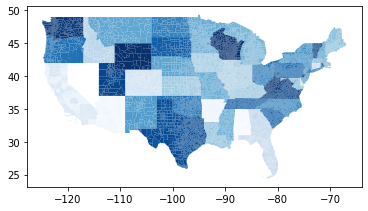

In [39]:
# Import U.S. census tract shapefiles
censusTract_stateIDs = list(range(1,57))
removeVals = [3, 7, 14, 32, 43, 52] # not US state or DC
nonContiguous = [2,15] # [Hawaii, Alaska]
censusTract_stateIDs = [i for i in censusTract_stateIDs if i not in removeVals]
censusTract_stateIDs_contiguous = [i for i in censusTract_stateIDs if i not in nonContiguous]

for n in censusTract_stateIDs_contiguous:
    if n < 10:
        tractID = '0'+str(n)
    else:
        tractID = str(n)
    
    tract_temp = gpd.read_file(f'./data/censusTracts_2018/tl_2018_{tractID}_tract/tl_2018_{tractID}_tract.shp')
    tract_temp = tract_temp[['GEOID','geometry']]
        
    if n == 1:
        US_tracts = tract_temp.copy()
    else:
        frames = [US_tracts,tract_temp]
        US_tracts = pd.concat(frames, sort=False)
       
US_tracts.plot("GEOID", cmap="Blues")  
US_tracts.head()

In [36]:
# Merge Income data and tract geometry
incomeData_tractGeometry = US_tracts.merge(medianIncome_2018,
                                      left_on="GEOID",
                                      right_on='GEOID',
                                      how = 'left')
incomeData_tractGeometry.head()

,GEOID,geometry,Median income (dollars)
0,01087232100,"POLYGON ((-85.73401 32.40810, -85.73390 32.408...",37098
1,01101002201,"POLYGON ((-86.31642 32.34430, -86.31624 32.344...",26829
2,01101002202,"POLYGON ((-86.31681 32.32241, -86.31599 32.322...",31276
3,01101002300,"POLYGON ((-86.33477 32.32758, -86.33457 32.328...",26553
4,01101002400,"POLYGON ((-86.34781 32.32959, -86.34670 32.332...",29250


## Visualization 1:  Map of BA-to-BA electric transfers

- How is electricity, and subsequently embedded resources and emissions, transferred around the U.S.?

In [31]:
# necessary data in the dataframe ...

## Visualization 2:  Map of Point Source GHG Emissions

- How are greenhouse gases spatially emitted by electricty generation in the U.S.?

In [32]:
# necessary data in the dataframe 'fuelAndGeneration_2018_location'
fuelAndGeneration_2018_location

,Month,Plant ID,Latitude,Longitude,Balancing Authority Code,GHG Estimate (lbs),Net Generation (MWh)
0,1,3,31.006900,-88.010300,SOCO,3.385828e+08,1267682.0
1,1,7,34.012800,-85.970800,SOCO,4.145301e+06,14592.0
2,1,8,33.644344,-87.196486,SOCO,2.683336e+08,665047.0
3,1,9,31.756900,-106.375000,EPE,1.432610e+06,3601.0
4,1,10,32.601700,-87.781100,SOCO,2.123426e+07,72463.0
...,...,...,...,...,...,...,...
39044,12,62574,34.196324,-118.448225,LDWP,1.204141e+05,745.0
39045,12,62625,41.880900,-71.092700,ISNE,7.047219e+03,22.0
39046,12,62658,41.141773,-81.474535,PJM,1.871391e+04,58.0
39047,12,62762,29.562372,-95.089302,ERCO,2.004517e+06,7315.0


In [33]:
# How many unique plants are there?
print(fuelAndGeneration_2018_location['Plant ID'].nunique())

3326


In [34]:
# Reduce the number of plants to visualize

#The emissions threshold sets the lower limit of emissios based on quantiles
emissions_threshold2 = fuelAndGeneration_2018_location['GHG Estimate (lbs)'].quantile(.25)

viz2 = fuelAndGeneration_2018_location[fuelAndGeneration_2018_location['GHG Estimate (lbs)'] > emissions_threshold2]
print(viz2['Plant ID'].nunique())

2630


## Visualization 3:  Map of Power Plants & Fuel Type and Median Household Income

- What is the relationship between power plants (and subsequently emissions and pollution) and wealth?

In [35]:
# necessary data in the dataframe 'emissions_primaryFuelType'
emissions_primaryFuelType

,Month,Plant ID,Latitude,Longitude,Balancing Authority Code,GHG Estimate (lbs),Net Generation (MWh),Reported Fuel Type Code
0,1,3,31.006900,-88.010300,SOCO,3.385828e+08,1267682.0,COAL_NG
1,1,7,34.012800,-85.970800,SOCO,4.145301e+06,14592.0,NG
2,1,8,33.644344,-87.196486,SOCO,2.683336e+08,665047.0,COAL
3,1,9,31.756900,-106.375000,EPE,1.432610e+06,3601.0,NG
4,1,10,32.601700,-87.781100,SOCO,2.123426e+07,72463.0,NG
...,...,...,...,...,...,...,...,...
37054,12,62456,41.077952,-73.820649,NYIS,1.251603e+05,824.0,NG
37055,12,62458,34.081450,-118.151910,CISO,1.105121e+05,236.0,NG
37056,12,62459,37.378422,-121.899969,CISO,1.192577e+04,805.0,NG
37057,12,62574,34.196324,-118.448225,LDWP,1.204141e+05,745.0,NG


In [36]:
incomeData_tractGeometry

,GEOID,geometry,Median income (dollars)
0,01087232100,"POLYGON ((-85.73401 32.40810, -85.73390 32.408...",37098
1,01101002201,"POLYGON ((-86.31642 32.34430, -86.31624 32.344...",26829
2,01101002202,"POLYGON ((-86.31681 32.32241, -86.31599 32.322...",31276
3,01101002300,"POLYGON ((-86.33477 32.32758, -86.33457 32.328...",26553
4,01101002400,"POLYGON ((-86.34781 32.32959, -86.34670 32.332...",29250
...,...,...,...
72364,56039967800,"POLYGON ((-110.83851 43.46562, -110.83834 43.4...",82123
72365,56009956500,"POLYGON ((-105.47360 42.72471, -105.47311 42.7...",70147
72366,56009956400,"POLYGON ((-105.42173 42.80177, -105.42172 42.8...",53805
72367,56009956600,"POLYGON ((-106.07824 43.47968, -106.07820 43.4...",84957


### Project Roles

- **Jenni Nugent**:  Data cleaning and preparation
- **Guangyu Cai**:   Visualization 1
- **Amina Jackson**: Visualization 2
- **Joe Franke**:    Visualization 3